<a href="https://colab.research.google.com/github/AryanNesti/Electromyography-and-Gradient-Boosting/blob/main/Electromyography%20and%20Gradient%20Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Electromyography and Gradient Boosting
## Background and Documentation
### Gradient Boosting
#### History
Graident boosing is very popular and you will most likley see it more often if you are continuing a future in machine learning. The most common recipe for Gradient Boosting is XGBoost which is the standard for winning machine learning competitions. The idea of Gradient Boosting came from can we make a strong model using these simplier/weaker models. Before gradient boosting there was a model called Adaboost which was a greedy algorithm that build a linear combination of simple models by re-weighing the input data. Then, the model (usually a decision tree) is built on earlier incorrectly predicted objects, which are now given larger weights. Adaboost worked miracles but with little explanation at the time to its miracles people though it was just overfitting. This overfitting problem did exist and thats why a few professors in the statistics department at Stanford, who had created Lasso, Elastic Net, and Random Forest, created Gradient Boosting Machine. 

#### How Gradient Boosting Works
Gradient boosting models combines the work of several weaker models o create a strong model.  Gradient boosting optimizes the mean squared error (MSE), also called the L2 loss or cost. The more weaker models used the more the MSE is reduced. To construct a boosted regression model, let's start by creating a crappy model, $f_{0}(x)$ , that predicts an initial approximation of $y$ given feature vector . Then, let's gradually nudge the overall $F_{m}(x)$ model towards the known target value y by adding one or more tweaks, $\Delta_m(x)$. Therefore 
$$\hat{y}= f_{0}(x) + \Delta_1(x) + \Delta_2(x) + \Delta_3(x) +\ ... \ + \Delta_M(x)$$ 
Optimizing a model according to MSE makes it chase outliers because squaring the difference between targets and predicted values emphasizes extreme values. When we can't remove outliers, it's better to optimize the mean absolute error.

#### Gradient Boosting Regression
Gradient Boosting regression would be a similar case 
to Gradient Boosting, however we now involve the learning rate.
$$ F_m(X) = F_{m-1}(X) + ηΔ_m(X) $$
therefore:
$$F_1(X) = F_{0} + ηΔ_1(X),  F_2(X) = F_{1} + ηΔ_2(X),$$

#### Modeling Performance
To answer that, we need a loss or cost function, $L(y,\hat{y})$ or $L(y_i,\hat{y}_i)$, that computes the cost of predicting $\hat{y}$ instead of $y$. The loss across all $N$ observations is just the average (or the sum if you want since $N$ is a constant once we start training) of all the individual observation losses:
$$L(y, F_M(X)) = \frac{1}{N}Σ^{N}_{i = 1}L(y_i- F_M(x_i))$$
The mean squared error (MSE) is the most common:
$$L(y, F_M(X)) = \frac{1}{N}Σ^{N}_{i = 1}(y_i- F_M(x_i))^2$$

#### Hyper-parameters
The two parameters we discuss are the number of stages M and the learning rate . Both affect model accuracy. The more stages we use, the more accurate the model, but the more likely we are to be overfitting. The primary value of the learning rate is to reduce overfitting of the overall model. As a side note, the idea of using a learning rate to reduce overfitting in models that optimize cost functions to learn, such as deep learning neural networks, is very common. Rather than using a constant learning rate, though, we could start the learning rate out energetically and gradually slow it down as the model approached optimality. For our experiments we stuck to a fixed parameters:
$$M = 200, η = 1$$ (which is the default learning rate for the decision tree we are using.)

The most common recipe for Gradient Boosting is XGBoost which is the standard for winning machine learning competitions. However here we will use Sklearn DecisionTreeClassifier and develop our own gradient boosting from scratch.

## Coding from scratch using JAX

fatal: destination path 'data-science-from-scratch' already exists and is not an empty directory.
mv: cannot move 'data-science-from-scratch' to 'dsfs/data-science-from-scratch': Directory not empty


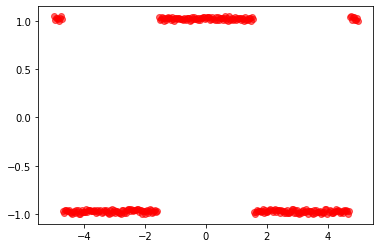

<Figure size 720x720 with 0 Axes>

In [89]:
import jax.numpy as jnp
from jax import jit
import jax
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
! git clone https://github.com/joelgrus/data-science-from-scratch
! mv data-science-from-scratch dsfs
from dsfs.scratch import decision_trees as sdt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

# set the number of examples
number_of_examples = 300

# fix the seed for reproducibility
key = jax.random.PRNGKey(42)

# generate features
X = jnp.linspace(-5, 5, number_of_examples)

# generate target
y = jnp.array(list(map(lambda x: 1.0 if jnp.cos(x) >= 0 else -1.0, X)))
epsilon = 0.05
# y += epsilon * np.random.randn(number_of_examples)
y += epsilon * jax.random.uniform(key, shape=(number_of_examples,))

# create pandas.DataFrame
data = pd.DataFrame(data=jnp.stack([X, y], axis=1), columns=["X", "y"])
data = data.astype({'X': float, 'y': float})
data.head()

# Splitting data 70 and 30
X_train, X_test, y_train, y_test = train_test_split(data[['X']], data[['y']], test_size=0.3, random_state=42)
X_train, y_train = X_train.sort_index(), y_train.sort_index()
X_test, y_test = X_test.sort_index(), y_test.sort_index()
y_train = jnp.round_(jnp.array(y_train)[:,0])

# Plotting the data
plt.scatter(X, y, c ="red", alpha=0.6)
plt.figure(figsize=(10, 10))
plt.show()

We implement gradient boosting as explained above, we keep the learning rate default and max_depth of 1. Here we will save the models and then look at the accuracy of our model

In [90]:
from sklearn.tree import DecisionTreeClassifier
max_depth = 1

# Training the sklearn DecisionTreeClassifier as Gradient Boosting
F0 = y_train.mean().astype('int')
Fm = F0
trees = []
for _ in range(number_of_examples):
    tree = DecisionTreeClassifier(max_depth=max_depth)
    tree.fit(X_train, y_train - Fm)
    Fm += tree.predict(X_train)
    trees.append(tree)

test_y_hat = jnp.add(jnp.array(F0), jnp.sum(jnp.array([t.predict(X_test) for t in trees]), axis=0))
train_y_hat = jnp.add(jnp.array(F0), jnp.sum(jnp.array([t.predict(X_train) for t in trees]), axis=0))

acc = 0
for i in range(len(y_train)):
  if (train_y_hat[i] == y_train[i]):
    acc += 1

print("Training accuracy: " + str(acc / len(y_train)))
acc = 0
for i in range(len(y_test)):
  if (test_y_hat[i] == jnp.round_(jnp.array(y_test)[i])):
    acc += 1
print("Validation accuracy: " + str(acc / len(y_test)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Explicitly requested dtype int requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  """


Training accuracy: 1.0
Validation accuracy: 0.9888888888888889


This function plots the model predictions which was provided in class for learning purposes and was edited for our model.

In [91]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):

  y_hat = sum(regressor.predict(X) for regressor in regressors)


  plt.plot(X, y, data_style, label=data_label)
  plt.plot(X, y_hat, style, linewidth=2, label=label)

  if label or data_label:
    plt.legend(loc="right")

  plt.ylabel("$y$")
  plt.xlabel("$X$")
  plt.show()


Using the saved models we now graph our model to further see our accuracy

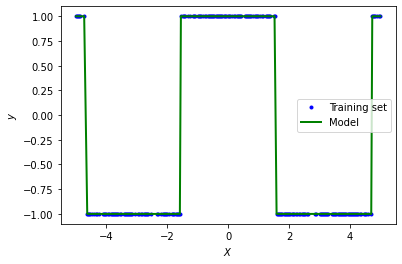

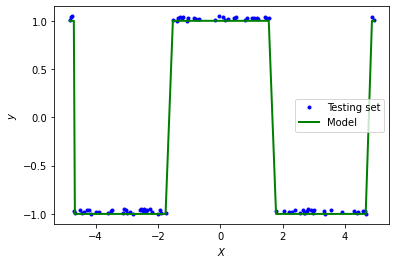

In [92]:

preds = plot_predictions(
    trees, X_train, y_train, axes=[-5, 5, -0.2, 1.2], label="Model", style="g-", data_label="Training set"
)

preds = plot_predictions(
    trees, X_test, y_test, axes=[-5, 5, -0.2, 1.2], label="Model", style="g-", data_label="Testing set"
)

## EMG Dataset

In [93]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Accessing and Opening the EMG dataset, and collecting the data required to implement a model.

In [94]:
import os


actions = {} #defining an empty dictionary for action names and corresponding labels

# Using all subjects' data
data_dirs = ["gdrive/MyDrive/EMG Physical Action Data Set/sub1/Aggressive/txt/",
             "gdrive/MyDrive/EMG Physical Action Data Set/sub1/Normal/txt/",
             "gdrive/MyDrive/EMG Physical Action Data Set/sub2/Aggressive/txt/",
             "gdrive/MyDrive/EMG Physical Action Data Set/sub2/Normal/txt/",
             "gdrive/MyDrive/EMG Physical Action Data Set/sub3/Aggressive/txt/",
             "gdrive/MyDrive/EMG Physical Action Data Set/sub3/Normal/txt/",
             "gdrive/MyDrive/EMG Physical Action Data Set/sub4/Aggressive/txt/",
             "gdrive/MyDrive/EMG Physical Action Data Set/sub4/Normal/txt/",]

ind = 0
data = pd.DataFrame()

for dirs in data_dirs:
  for files in os.listdir(dirs):
    with open(os.path.join(dirs, files), "r") as f:  # from all the files within all the dirs, read the tab separated files.
     # Extracting the 8 columns names from filenames
      temp = pd.read_csv(f.name, sep = "\t", header = None, names = ["ch" + str(i) for i in range(1, 9)])

      # chunking using Max of every 10 sequential values.
      temp_chunked = pd.DataFrame()

      for i in range(0, len(temp), 10):
        temp_chunked = temp_chunked.append(temp.iloc[i:i+10].max(), ignore_index = True)

      # Defining the class labels 
      labels = [files[:-4] for i in range(len(temp_chunked))] # remove the last 4 characters=".txt" from the filename to get the activity name
      actions[files[:-4]] = ind # We have about 20 activity classes and they are assigned a numeric labels in the actions dictionary.
      temp_chunked["Action"] = labels

      # Final Data
      data = pd.concat([data, temp_chunked])

      ind+=1

print(actions)

{'Slapping': 61, 'Sidekicking': 60, 'Pushing': 62, 'Punching': 65, 'Pulling': 64, 'Kneeing': 63, 'Headering': 66, 'Hamering': 67, 'Frontkicking': 68, 'Elbowing': 69, 'Waving': 70, 'Walking': 72, 'Running': 73, 'Standing': 74, 'Jumping': 71, 'Hugging': 76, 'Handshaking': 77, 'Seating': 75, 'Bowing': 78, 'Clapping': 79}


In [95]:
data.head(100)

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Action
0,2.0,113.0,129.0,95.0,-1042.0,845.0,-94.0,-407.0,Slapping
1,4000.0,250.0,-54.0,142.0,-2550.0,303.0,-1458.0,1765.0,Slapping
2,2410.0,1516.0,803.0,8.0,3284.0,309.0,-1877.0,1199.0,Slapping
3,-1556.0,876.0,710.0,85.0,4000.0,213.0,-1517.0,646.0,Slapping
4,4000.0,275.0,304.0,137.0,4000.0,180.0,238.0,251.0,Slapping
...,...,...,...,...,...,...,...,...,...
95,74.0,40.0,93.0,142.0,407.0,230.0,-4000.0,336.0,Slapping
96,188.0,130.0,400.0,76.0,1525.0,183.0,-3924.0,418.0,Slapping
97,260.0,164.0,-49.0,116.0,1660.0,449.0,1866.0,145.0,Slapping
98,8.0,160.0,241.0,92.0,1242.0,367.0,4000.0,1338.0,Slapping


Defining our data:
<br>
X is all the data without the labels of what action it is
<br>
Y is the list of actions the coresponding data points are

In [96]:
x=data.drop(["Action"], axis=1)
y=data["Action"]
y = y.map(actions)

Seperate the data for training and testing purposes

In [97]:
from sklearn.model_selection import train_test_split
import numpy as np


X = jnp.array(x.values.tolist())
y = jnp.array(y.values.tolist())

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2) # 80-20 split
print(f"Sizes of the sets created are:\nTraining set:{X_train.shape[0]}\nTest set:{X_test.shape[0]}")

Sizes of the sets created are:
Training set:63810
Test set:15953


Implementing the Gradient Descent using Sklearn's DecisionTreeClassifier spoken about above and also implemented previously with the cosinusoidal dataset.

In [98]:
max_depth = 7

# Training the sklearn DecisionTreeClassifier as Gradient Boosting
y_train = jnp.round_(jnp.array(y_train))
F0 = y_train.mean().astype('int')
Fm = F0
trees = []
for _ in range(number_of_examples):
    tree = DecisionTreeClassifier(max_depth=max_depth)
    tree.fit(X_train, Y_train - Fm)
    Fm += tree.predict(X_train)
    trees.append(tree)


test_y_hat = jnp.add(jnp.array(F0), jnp.sum(jnp.array([t.predict(X_test) for t in trees]), axis=0))
train_y_hat = jnp.add(jnp.array(F0), jnp.sum(jnp.array([t.predict(X_train) for t in trees]), axis=0))

# Calculating the accuracy of hte model
acc = 0
for i in range(len(Y_train)):
  if (train_y_hat[i] == Y_train[i]):
    acc += 1

print("Training accuracy: " + str(acc / len(Y_train)))
acc = 0
for i in range(len(Y_test)):
  if (test_y_hat[i] == Y_test[i]):
    acc += 1
print("Validation accuracy: " + str(acc / len(Y_test)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Explicitly requested dtype int requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  """


Training accuracy: 0.33253408556652564
Validation accuracy: 0.3211935059236507
